In [1]:
import keras.backend as K
import matplotlib.pylab as plt
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda
from nltk.corpus import inaugural, stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE
import spacy, numpy, pandas, os

In [2]:
names = inaugural.fileids()
speech = inaugural.raw(fileids = names[36]) # FDR 1933

In [3]:
def preprocess(text):
    
    sentences = sent_tokenize(text)
    
    punctuation = ['.', ',', ';', '!', '?', '--']
    sw = stopwords.words('english')
    nlp = spacy.load('en_core_web_sm')
    
    lemmas = []
    
    for sentence in sentences: # Lemmatize
        lemmas.append([word.lemma_ for word in nlp(sentence) if word.lemma_ != '-PRON-'])
        
    tokens = []
    
    for sentence in lemmas: # Lowercase; remove stopwords and punctuation
        tokens.append([word.lower() for word in sentence
                       if word.lower() not in punctuation
                       and word.lower() not in sw
                       and word != "\'s"])
    
    corpus = []
    
    for sentence in tokens:
        tmp = ' '.join(sentence)
        corpus.append(tmp)
    
    return corpus

In [4]:
corpus = preprocess(speech)

In [5]:
def word2id(corpus):
    
    tokenizer = text.Tokenizer()
    tokenizer.fit_on_texts(corpus)
    
    return tokenizer.word_index

In [6]:
word2id = word2id(corpus)

In [7]:
word2id['PAD'] = 0

In [8]:
def id2word(word2id):

    return {v:k for k, v in word2id.items()}

In [9]:
id2word = id2word(word2id)

In [10]:
def wids(corpus, word2id):
    
    return [[word2id[word] for word in text.text_to_word_sequence(token)] for token in corpus]

In [11]:
wids = wids(corpus, word2id)

In [12]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    
    context_length = window_size*2
    
    for words in corpus:
        
        sentence_length = len(words)
        
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [13]:
def get_samples(n, window_size = 2, vocab_size = len(word2id)):
    
    samples = []
    
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size = window_size, vocab_size = vocab_size):
        if 0 not in x[0]:
            
            samples.append(([id2word[w] for w in x[0]], id2word[numpy.argwhere(y[0])[0][0]]))
    
            if i == n-1:
                break
            i += 1
            
    return samples

In [14]:
def print_samples(n):

    samples = []

    for i in get_samples(n):
        context = ', '.join(i[0])
        target = i[1]
        samples.append((context, target))

    table = pandas.DataFrame(samples, columns = ['Context', 'Target'])
    output = table.style.set_properties(**{'text-align': 'left'})
    output = output.set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])])
  
    display(output)

In [15]:
print_samples(5)

,Context,Target
0,"certain, fellow, expect, induction",americans
1,"fellow, americans, induction, presidency",expect
2,"americans, expect, presidency, address",induction
3,"expect, induction, address, candor",presidency
4,"induction, presidency, candor, decision",address


In [16]:
def build_CBOW(window_size = 2, vocab_size = len(word2id), embed_size = 100):
    
    cbow = Sequential()
    
    cbow.add(
        Embedding(
        input_dim = vocab_size, 
        output_dim = embed_size, 
        input_length = window_size * 2
        )
    )
    
    cbow.add(
        Lambda(
            lambda x: K.mean(x, axis=1), 
            output_shape=(embed_size,)
        )
    )
    
    cbow.add(
        Dense(
            vocab_size, 
            activation='softmax'
        )
    )
    
    cbow.compile(
        loss='categorical_crossentropy', 
        optimizer='rmsprop'
    )
    
    return cbow

In [17]:
cbow = build_CBOW()
cbow.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4, 100)            56700     
_________________________________________________________________
lambda (Lambda)              (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 567)               57267     
Total params: 113,967
Trainable params: 113,967
Non-trainable params: 0
_________________________________________________________________


In [18]:
def train_CBOW(epochs, cbow = cbow, corpus = wids, window_size = 2, vocab_size = len(word2id)):
    
    train_CBOW = []
    
    for epoch in range(1, epochs + 1):
        loss = 0.
        i = 0
        for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
            i += 1
            loss += cbow.train_on_batch(x, y)

        train_CBOW.append((epoch, loss))
    
    return train_CBOW

In [19]:
train_CBOW = train_CBOW(50)

In [20]:
train_table = pandas.DataFrame(train_CBOW, columns = ['Epoch ', 'Loss'])
print(
    train_table.to_string(
        index = False,
        justify = 'center',
        col_space = (0, 15),
        max_rows = 10
    )
)

 Epoch        Loss     
    1     5777.402314  
    2     5714.508174  
    3     5645.885254  
    4     5568.796554  
    5     5482.531992  
...                 ...
   46     3108.607861  
   47     3071.721228  
   48     3035.183831  
   49     2999.065655  
   50     2963.431799  


In [21]:
weights = cbow.get_weights()[0]
weights = weights[1:]

In [25]:
def similar_words(weights, search_terms):
    distance_matrix = euclidean_distances(weights)

    similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in search_terms}

    return similar_words

In [26]:
search_terms = ['leadership', 'government', 'constitution', 'emergency', 'economy']
similar_words = similar_words(weights, search_terms)

In [27]:
table_similar_words = pandas.DataFrame(similar_words)
display(table_similar_words)

,leadership,government,constitution,emergency,economy
0,property,city,simple,fact,less
1,become,quickly,always,narrowly,currency
2,frankness,local,line,primary,house
3,life,inherit,less,invade,establishment
4,submit,planning,favor,courageously,unequal


In [48]:
def visualize_distance(similar_words = similar_words, word2id = word2id):
    
    words = sum([[k] + v for k,v in similar_words.items()], [])
    words = list(set(words))
    words_ids = [word2id[w] for w in words]
    word_vectors = numpy.array([weights[idx] for idx in words_ids])
    
    print("Total Words: ", len(words), "\tWord Embedding Shapes: ", word_vectors.shape)
    
    tsne = TSNE(
        n_components = 2, 
        random_state = 0,
        n_iter = 10000,
        perplexity = 3
    )
    
    numpy.set_printoptions(suppress = True)
    
    T = tsne.fit_transform(word_vectors)
    
    labels = words
    plt.figure(figsize = (20, 10))
    plt.scatter(
        T[:, 0], T[:, 1], 
        c = "steelblue",
        edgecolors = "k",
        s = 40
    )
    
    for label, x, y in zip(labels, T[:, 0], T[:, 1]):
        plt.annotate(
            label,
            xy = (x + 1, y + 1),
            xytext = (-5, 7),
            textcoords = "offset points",
            fontsize = 12
        )

Total Words:  29 	Word Embedding Shapes:  (29, 100)


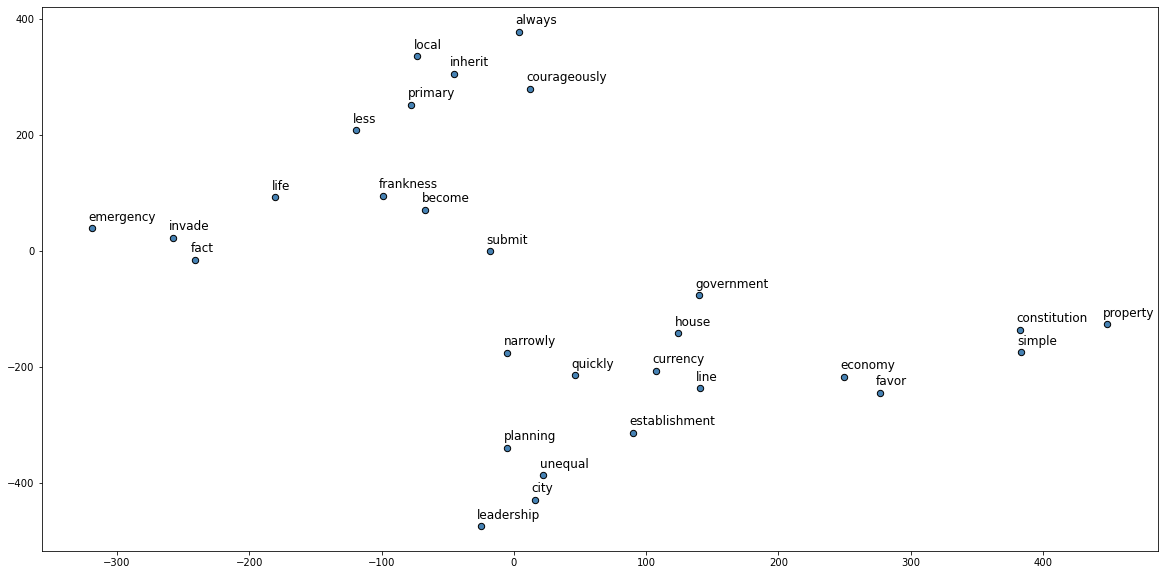

In [49]:
visualize_distance()